In [59]:
from IPython.html.services.config import ConfigManager
from IPython.utils.path import locate_profile
cm = ConfigManager(profile_dir=locate_profile(get_ipython().profile))
cm.update('livereveal', {
              'theme': 'sky',
              'transition': 'zoom',
              'start_slideshow_at': 'selected',
})
%load_ext tikzmagic

/Users/ivan/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/Users/ivan/anaconda/lib/python2.7/site-packages/IPython/utils/path.py:282: UserWarning: locate_profile has moved to the IPython.paths module
  warn("locate_profile has moved to the IPython.paths module")


# Quantized tensor train technology for partial differential equations

##### Ivan Oseledets, joint work with Christoph Schwab, Vladimir Kazeev, Maxim Rakhuba

## Outline of the talk
- A brief description adaptive solution methods for partial differential equations (PDEs)
- Tensorization and tensor trains: ideas and basic facts
- How it (can) work for complex domains
- How it (can) work for multiscale problems

## Where PDEs appear

PDEs are the #1 tool in physical modelling:

1. Heat conduction
2. Computational fluid dynamics
3. Elasticity
4. Electromagnetic phenomena
5. Many more

## Numerical methods for solving PDEs
The numerical methods for PDEs are well-established:

1. Discretize the domain with polygons (trianges, quadrilaterals)
2. Approximate the solution with a linear combination of "local" basis functions.
3. Write down the linear system of coefficients
4. Solve it.

Typically, the "order" of the numerical scheme is considered, i.e.

$$\Vert u - u_h \Vert = \mathcal{O}(h^p),$$

where $h$ is the <font color='red'> grid size </font>

## A textbook example

A textbook example is the **Poisson equation:**

$$\Delta u = f, \quad u_{\mid \partial \Omega} = 0.$$

The Finite Element Method (FEM) techniques are extremely well-developed, even in the technological view.

## FEM-method

We write down the **weak formulation** for the equation,

$$-\int \nabla u \nabla v dx = \int f v dx, \quad v \in W^{2}_1,$$

and then use the **Galerkin method**, replacing $u$ by $\sum_i u_i \varphi_i$ and testing the weak equation with $v = \phi_j$.

You can do it **automatically** using the [FeNics](fenicsproject.org) or [Firedrake](firedrakeproject.org) software.

In [76]:
from firedrake import *
n = 128

mesh = UnitSquareMesh(n, n)
V = FunctionSpace(mesh, "CG", 2)
bc0 = DirichletBC(V, Expression(("0")), 1)
bc1 = DirichletBC(V, Expression(("0")), 2)
bc2 = DirichletBC(V, Expression(("0")), 3)
#bc3 = DirichletBC(V, Expression(("0")), 4)
bcs = [bc0, bc1, bc2]
u = TrialFunction(V)
v = TestFunction(V)
f = Function(V)
f.interpolate(Expression("1"))
#a = ( dot(grad(v), grad(u))) * dx
#frm = assemble(a, bcs=bcs)
L = f * v * dx
L1 = assemble(L)
a = (dot(grad(v), grad(u))) * dx
frm = assemble(a, bcs=bcs)
sol = Function(V)
solve(frm, sol, L1, solver_parameters={'ksp_type': 'cg'})
sol.vector().array()
#sol = Function(V)
#solve(a, sol, L1, solver_parameters={'ksp_type': 'cg'})

array([  0.00000000e+00,   0.00000000e+00,   5.27206826e-05, ...,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])

ValueError: z array must have same length as triangulation xand y arrays

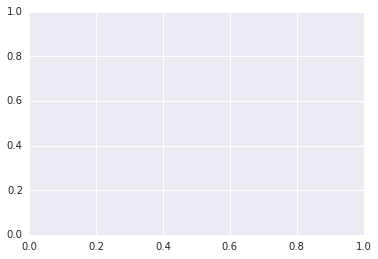

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
u0 = sol.vector().array()
p1 = mesh.coordinates.vector().array().reshape((-1, 2)) 
plt.tricontourf(p1[:, 0], p1[:, 1], u0)

## Challenges

What are the challenges, if FEM (and also other techniques, like Finite Volume, Finite Difference methods) are so well-developed?

There are several:

- <font color='red'> Computational complexity: </font> in 3D problems we have to store $n^3$ elements, and even for a second-order scheme it might be a lot.
- <font color='red'> Need for **adaptivity**: </font> if there are **corners** in the domain (i.e., polygonal domain), the solution has singularity there, 
- <font color='red'> Multiscale problems: </font> for highly oscillating coefficients, we need to resolve the finest scale with the local basis functions (or go to global basis functions that have their own disadvantages).

## Adaptivity

There are different ways to adapt the solution to get **better accuracy** for the same number of **degrees of freedom**.

<img src='hp-refinement.png' >

Hp-refinement is the **most efficient method**, but it is technically very non-trivial to implement, 

and requires the knowledge of where the singularity is, what is the order of the singularity of the solution, 

## Multiscale problems

Model problem: heat conduction in a (quasi-periodic) domain

$$ \nabla \cdot (k \nabla u) = f,$$

where $k = k(\frac{x}{\delta},x)$, and $\delta$ is the scale parameter.

<img src='perforated-domain.jpg'>

## Periodic and quasiperiodic structures

Periodic/quasiperiodic structures are now used everywhere in photonics, composite materials, since by carefully designing such structure, you can get whatever properties you want.

## Solving multiscale problems

Small-order FEM is not the best tool to solve multiscale (even two-scale) problems:

we have to resolve the finest scale, and that leads to **huge grids** and grid adaptivity will not help.

## Homogenization

The homogenization technique, pioneered by Russian mathematicians Nikolay Sergeevich Bakhalov and Grigoriy Alekseevich Panasenko.

Осреднение процессов в периодических средах: математические задачи механики композиционных материалов, 1961

<div style="float: left; width: 40%">
<p style="text-align: center"> Н. С. Бахвалов </p>
<img src='bakhvalov.jpeg' width=100%>
</div>
<div style="float: left; width: 40%">
<p style="text-align: center"> Г. А. Панасенко</p>
<img src='panasenko.jpeg' width=100%>
</div>

## Idea of homogenization

$$ \nabla \cdot (k \nabla u) = f,$$

where $k = k(\frac{x}{\delta})$ -- periodic case.

Is to expand the solution in "series" of small parameter $\delta$.

The "zero"-order approximation is to replace $k$ by the **averaged** coefficient over the unit cell:

$$ \nabla \cdot (k_0 \nabla u_0) = f,$$

and $k_0$ is the **effective coefficient**.

Next terms include expansion of the solution as

$$
   u(x, \frac{x}{\delta})  = u_0 + \delta \sigma(\delta^{-1} \rho(x)) u_1\left(x, \frac{x}{\delta}\right),
   $$
   
   where $\sigma(0) = 0, 0 \leq \sigma(t) \leq 1$ for $0 \leq t \leq 1$ and $\sigma(t) = 1$ for all $t \geq 1$.
   
$\rho$ is the distance to the boundary.




## Homogenization

For many problems, the asymptotic expansions are written. They include boundary layers, quasi-periodic coefficients, vector problems.

Computational complexity is solving several **unit cells** problems (with different boundary conditions).



<font color='red'> Main problem: a lot of analytic work, not 100% flexible (i.e., you want to make a defect in one point) </font>

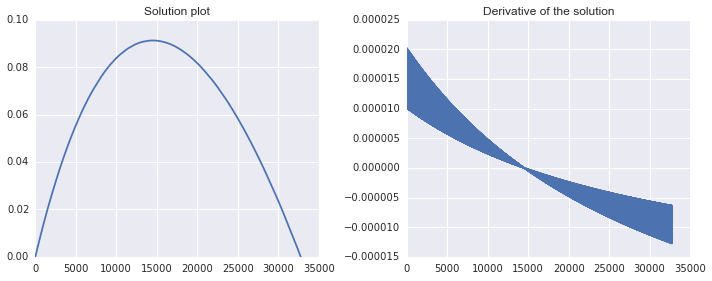

In [70]:
#Generate sparse tridiag matrix for div K grad
import scipy.sparse
import numpy as np
def Kfun(x, eps):
    return (1 + x) * 2/3 * (1 + np.cos(2 * np.pi * (x/eps)) ** 2)

def gen_full_matrix(d, eps, Kfun, a=0.0, b=1.0): 
    N = 2 ** d
    t = np.arange(N)
    e = np.ones(N)
    h = (b - a)/(N + 1)
    cf = (t + 0.5 * e) * h
    am = Kfun(cf, eps)
    cf_plus = (t + 1.5 * e) * h
    aa = (np.arange(N+1) + 0.5 * np.ones(N+1)) * h
    aa = Kfun(aa, eps)
    ap = Kfun(cf_plus, eps)
    dg = am + ap
    mat = scipy.sparse.spdiags([-am, -ap, dg], [1, -1, 0], N, N)
    mat = mat/h**2
    return aa, am, ap, mat


d = 15
eps = 1e-3
mat = gen_full_matrix(d, eps, Kfun)[-1]
rhs = np.ones(mat.shape[0])
sol = scipy.sparse.linalg.spsolve(mat, rhs)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(sol)
ax[1].plot(np.diff(sol))
ax[0].set_title('Solution plot')
ax[1].set_title('Derivative of the solution')
fig.tight_layout()

## What else can we do?

We propose something completely different, and it is based on:

1. Low-order FEM approximation
2. Quantized Tensor Train decomposition

## Quantized Tensor Train decomposition

The idea of QTT is very simple (and has been around for many many years).

Suppose we have a one-dimensional function, that is sampled on a uniform grid with $2^d$ points.

$$v_k = f(x_k), \quad k = 1, \ldots, 2^d$$

Then we reshape this vector into $2 \times 2 \times \ldots \times 2$  $d$-dimensional tensor:

$$V(i_1, \ldots, i_d) = v(i), \quad i = i_1+ 2 i_1 + \ldots 2^{d-1} i_d.$$

## Exponential case

Consider exponential case, $f(x) = \exp(\lambda x)$. Then, the tensor $V$ breaks into the product:

$V(i_1, \ldots, i_d) = \exp(h(i_1 + \ldots + 2^{d-1} i_d)) = $

$V_1(i_1) V_2(i_2) \cdot \ldots \cdot V_d(i_d).$



<font color='red'> This is a special case of the **canonical representations** of tensors </font>

## Canonical decomposition 

Given a tensor $V(i_1, \ldots, i_d)$ we say that it is in the **canonical format**, if it is the sum of rank-1 tensors:

$$V(i_1, \ldots, i_d) = \sum_{\alpha=1}^r V_1(i_1, \alpha) \ldots V_d(i_d, \alpha).$$


For $d=2$ it reduces to the **low-rank** approximation of a matrix, thus for many years it was considered as a **multidimensional generalization** of the **singular value decomposition.**

## Problems with the canonical decomposition

Canonical decomposition has problems:

- The computation of the canonical rank $r$ is NP-hard
- The best rank-$r$ approximation may not exist

However, there exists another multidimensional generalization of the SVD, which may have larger number of parameters, but it is much easier to compute!

## Tensor-train decomposition

Tensor-train decomposition has the form

$$A(i_1, \ldots, i_d) = G_1(i_1) \ldots G_d(i_d),$$

where $G_k(i_k)$ is $r_{k-1} \times r_k$ for any fixed $i_k$, and $r_0 = r_d = 1$.

It is also known for many years as **matrix product states** in solid state physics (and used to approximate wavefunctions).

1. We can compute TT by sequential SVD decompositions. 
2. The set of fixed TT-rank tensors is closed, thus optimization over such manifolds is doable.

## QTT-decomposition

QTT decomposition = Quantization + TT

I.e. we take a function, sample it on a uniform grid, replace it by a $d$-dimensional tensor, approximate it by the TT-format.


We get $\mathcal{O}(d r^2)$  instead of $2^d$ parameters, but this is a **non-linear** representation.

<font color='red'> Main question: </font> what kind of functions can we represent in such way?

## Simple functions

1. Exponentials: rank 1
2. Sine/Cosine functions: rank 2
3. Polynomials of degree p: rank p+1
4. Rational functions: $\log \epsilon^{-1}$

Good news: class is "closed" under addition and multiplications, so any combinations of those suffice!

## Two (and higher) dimensional case

In two dimensions, if the domain is a square, the situation is the same:

Discretize on a tensor-product mesh, quantize each one-dimensional index and go.

But what to do for non-square domains?

One idea is to use characteristic functions, but it **does not work.**

The solution, proposed by Vladimir Kazeev and Christoph Schwab is astonishingly simple and efficient:  




<font color='red'> Introduce logically rectangular grids! </font>

## Mapping quadrilaterals to rectangles
(pictures made by Larisa Markeeva).

<div style="float: left; width: 40%">
<p style="text-align: center">  Quadrilateral </p>
<img src='quadr.png' width=100%>
</div>
<div style="float: left; width: 40%">
<p style="text-align: center"> Reference</p>
<img src='quadr1.png' width=100%>
</div>

## Logically rectangular grids o
(pictures made by Larisa Markeeva).
<div style="float: left; width: 40%">
<p style="text-align: center">  triangle </p>
<img src='triangle.png' width=100%>
</div>
<div style="float: left; width: 40%">
<p style="text-align: center"> Reference</p>
<img src='triangle1.png' width=100%>
</div>

## Mapping with quads

In general, mapping of a complicated surface with quads is a well-known problem in computational geometry, which can be solved using standard tools

<img src='bommes2013qmg.jpg' width=40%>

## Theoretical result

Kazeev and Schwab in the paper [Quantized tensor-structured finite elements
for second-order elliptic PDEs in two
dimensions](http://www.sam.math.ethz.ch/sam_reports/reports_final/reports2015/2015-24.pdf)

have proven the following theoretical result, which I very loosely formulate  as follows.

For a second-order PDE with analytic forcing, and for a given number of parameters $N$ in the QTT representation, there exists a QTT-FEM approximant such that

$$\Vert u - u_{QTT, h} \Vert_{\mathbb{H}_1} = \mathcal{O}(e^{-bN^{\alpha}}),$$

where $\alpha=\frac{1}{5}$ in their theoretical analysis (in experiments it is much better, $\alpha \approx \frac{1}{2}$).

## Idea of the proof

Idea of the proof is to use known results on the hp-method and on the regularity of the solutions in polygonal domains.

Singularities have very specific form (point singularities), which can be approximated in the QTT-format.

The remainder is the analytic function, which can be approximated by the Fourier series (and they have small QTT-rank).

## Consequences

We can take a low-order FEM on a very fine **virtual mesh.**

Formulate a **huge** linear system 

$$Ax = f,$$

and look for the solution in the TT-format.

The general concept is very simple: we reformulate the solution as a minimization of energy:

$$(Ax, x) - 2(f, x) \rightarrow \min,$$

and minimize over the set of tensors with bounded ranks.

This is **non-convex** minimization procedure with low-rank constraints, but with much fewer number of parameters, 
and we have developed a black-box software for solving such problems.

## Tensor train software

TT-Toolbox is our main software packages, available:

1. For MATLAB: http://github.com/oseledets/TT-Toolbox
2. For Python: http://github.com/oseledets/ttpy

In [71]:
import tt
from tt.amen import amen_solve
d = 8 
a = tt.qlaplace_dd([d, d, d])
rhs = tt.ones(2, 3*d)
sol = amen_solve(a, rhs, tt.rand(rhs.n), 1e-6) #Black-box solver
mem = int((sol.erank  ** 2) * sum(sol.n))
print('Full memory: {0: d}, QTT-memory: {1: d}'.format(np.prod(sol.n), mem))

Full memory:  16777216, QTT-memory:  42243


## Multiscale problems

Now let us get back to the multiscale problems.

There are two important examples of multiscale problems:

1. Periodic/quasi-periodic coefficients
2. Wave propagation (Helmholtz/Maxwell problems).


The concept is the same: introduce a virtual mesh that resolves the finest scale, approximate it.

We have recently proved (Kazeev, Schwab, Oseledets, Rakhuba) that the same result hold for 1D multiscale problems!

## Multiscale: theoretical result and idea

Given the equation

$$(k u')' = f, $$

where $K = K\left(x, \frac{x}{\delta}\right)$

the solution can be approximated by a QTT-interpolant with exponential convergence with respect to the number of parameters in the QTT-format. The number of parameters required to reach the accuracy is also logarithmic in the multiscale parameter $\delta$, i.e.

$$N_l \sim \log^{\alpha} \epsilon \log^{\beta} \delta.$$

## Numerical illustrations

For a two-scale problem
$$ 
(a u')' = 1, \quad u(1) = u(0) = 0,
$$
$$a(x) = a_0(x) a_1\left(\frac{x}{\delta}\right),$$
where $a_0 = 1 + x$, $a_1 = 2/3 (1 + \cos^2(2 \pi \frac{x}{\delta})).$


<div style="float: left; width: 50%">
<img src='diffusion.jpg' width=100%>
</div>
<div style="float: left; width: 50%">
<img src='diffusion1.jpg' width=100%>
</div>

## "Practical" implementation
A practical implementation is short, although not straightforward even in 1D.

In [1]:
import numpy as np
import tt
import tt.amen
from tt.amen import amen_solve
import time
from tt.multifuncrs2 import multifuncrs2
d = 50
N = 2 ** d
x = tt.ones(2, d)
h = 1.0/N
B = (tt.Toeplitz(x, kind='U') + tt.eye(2, d))#.full()
B = B * h
alpha = -0.5
st = time.time()
tau = 1e-8
t = tt.xfun(2, d)
x = t * h
eps = 1e-4
Kf = lambda x: Kfun(x, eps)
Kf = multifuncrs2([x], Kf, tau, verb=0)  
Kf = Kf.round(tau)
Kmat = tt.diag(Kf)
ed = tt.eye(2, d)
#idd = tt.matrix(np.array([[0, -1.0], [0, 0]]))
e00 = tt.matrix(np.array([[1.0, 0, 0], [0, 0, 0], [0, 0, 0]]))
e01 = tt.matrix(np.array([[0.0, -1.0, 0], [0, 0, 0], [0, 0, 0]]))
e11 = tt.matrix(np.array([[0, 0, 0], [0, 1.0, 0], [0, 0, 0]]))
e12 = tt.matrix(np.array([[0, 0, 0], [0, 0.0, -1.0], [0, 0, 0]]))
e22 = tt.matrix(np.array([[0, 0, 0], [0, 0.0, 0.0], [0, 0, 1.0]]))
big_mat = tt.kron(ed, e00) + tt.kron(B, e01) + tt.kron(Kmat, e11) + tt.kron(ed, e12) + tt.kron(ed, e22)
f = tt.ones(2, d)
alpha = -0.5
rhs1 = tt.matvec(B, f) + alpha * tt.ones(2, d)
ev = tt.tensor(np.array([0.0, 0.0, 1.0]))
rhs = tt.kron(rhs1, ev)
sol = amen_solve(big_mat, rhs, rhs, 1e-6)
st = time.time() - st
print 'Total computing time:', st
#sol_full = sol.full().flatten("F")
#u1 = sol_full[:N]
#w1 = sol_full[N:2*N]
#fig, ax = plt.subplots(1, 3, figsize=(12, 4))
#x0 = x.full().flatten("F")
#ax[0].plot(x0, u1)
#ax[0].set_title('Solution')
#ax[1].plot(x0, w1)
#ax[1].set_title('Derivative')
#ax[2].plot(w1[:60])
#ax[2].set_title('Zooming in the derivative')
#fig.text(0.5, -0.1, 'Eps = {0}, d = {1}'.format(eps, d), size=16)
#fig.tight_layout()
#ax[1]

NameError: global name 'Kfun' is not defined

## Yet another challenge 

Everything seems to be fine: 

1. Solution can be approximated in the QTT-format
2. There are tools for finding such a solution

But(!) there is an important problem with low-order FEM.

## Finite different do not work on very small meshes
Suppose we have a 1D Laplacian

$$\frac{u_{i-1} - 2 u_i + u_{i+1}}{h^2},$$

and the error in this is $\frac{\epsilon}{h^2} + h^2$, i.e. we can not go beyond $h \sim \epsilon^{1/4}.$

For a non-QTT-world, there is no problem: $\epsilon = 10^{-16}, \quad h \sim 10^{-4}$.

In our case, we need grids $2^{60}-2^{80}$, so this is a problem.

We need new discretization schemes (and I already used one in the example above).

## Future work

Our main goal is to establish the technology at all levels and show its efficiency in real applications.
We now have the theoretical ground.
- Quad-grid generation (working with D. Zorin)
- Form matrices in the QTT-format
- Improve the existing TT-optimization software
- Develop more appropriate "derivative-free" discretization schemes for very fine meshes.
- Apply to photonic crystal modelling 
- Apply to composite materials

In [58]:
from IPython.core.display import HTML
def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()